# Android Data from PlayStore

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load data
df = pd.read_csv('googleplaystore.csv')
df_user_reviews = pd.read_csv('googleplaystore_user_reviews.csv')
df.columns
df_user_reviews.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')

Index(['App', 'Translated_Review', 'Sentiment', 'Sentiment_Polarity',
       'Sentiment_Subjectivity'],
      dtype='object')

In [4]:
# rename columns
df.rename(columns={
    'App': 'name',
    'Category': 'category',
    'Rating': 'rating',
    'Reviews' :'reviews',
    'Size': 'size',
    'Installs': 'installs',
    'Type': 'type',
    'Price': 'price',
    'Content Rating': 'content_rating',
    'Genres': 'genres',
    'Last Updated': 'last_updated',
    'Current Ver': 'version',
    'Android Ver': 'android_version'
    
}, inplace=True)
df.head()

df_user_reviews.rename(
    columns={'App':'app_name', 'Translated_Review': 'review', 'Sentiment': 'sentiment', 'Sentiment_Polarity': 'polarity', 'Sentiment_Subjectivity': 'subjectivity'}
, inplace=True)
df_user_reviews.head()


,name,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,version,android_version
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


,app_name,review,sentiment,polarity,subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
name               10841 non-null object
category           10841 non-null object
rating             9367 non-null float64
reviews            10841 non-null object
size               10841 non-null object
installs           10841 non-null object
type               10840 non-null object
price              10841 non-null object
content_rating     10840 non-null object
genres             10841 non-null object
last_updated       10841 non-null object
version            10833 non-null object
android_version    10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [6]:
df.describe()

,rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


## Preprocessing
Many columns need preformatting to be able to use them in any machine learning models. They should be converted to numbers.

In [7]:
# preformat installs
df = df[df['installs'] != 'Free']
new_df = df['installs'].map(lambda s : s[:-1].replace(',',''))
new_df[new_df == ''] = 0
new_df.astype(int).unique()
df['installs'] = new_df.astype(int)

array([     10000,     500000,    5000000,   50000000,     100000,
            50000,    1000000,   10000000,       5000,  100000000,
       1000000000,       1000,  500000000,         50,        100,
              500,         10,          1,          5,          0])

In [8]:
# preformat reviews
df['reviews'] = df['reviews'].astype(int)

In [9]:
# Other preformat cells here !!!!!!!

## Feature engineering
Features below are derived from the original features of data

In [10]:
# preformat size
# np.sort(df['size'].unique())
def size_transform(size):
    if size == 'Varies with device':
        return 1
    unit = size[-1]
    number = float(size[:-1])
    if unit == 'M':
        return number * 1024 * 1024
    if unit == 'k':
        return number * 1024
df['size'] = df['size'].apply(size_transform).astype(int)

In [11]:
# preprocess last_updated
# keep only the year
df['last_year_updated'] = df['last_updated'].apply(lambda s : s[-4:]).astype(int)

# todo: maybe convert this column to datetime object

In [12]:
# preprocess name
# keep the word count of the app name
df['name_wc'] = df['name'].apply(lambda s : len(s.replace('&','').replace('-', '').split()))

In [13]:
# preprocess version & android_version
def vs_transform(version):
    if version == 'Varies with device':
        return -1
    if version == np.NaN or version == np.nan:
        return np.nan
    return version[0]
# there are some edge cases that still need to be cared about
df['version'].astype(str).sort_values()[-1600:]
# df['major_version'] = df['version'].astype(str).apply(vs_transform).astype(int)
# df['android_version'].astype(str).apply(vs_transform).astype(int)

10662                                   Android 3.0 - 2015
10650                                   Android 3.0 - 2017
8145                                    Android 3.1 - 2015
8151                                    Android 3.1 - 2017
7509                                         App copyright
6195                                             Arrow-202
6437                     BL ONLINE PERSONAL TRAINING 7.9.0
9644                                            BlueOrange
7507                                     Bowser4Craigslist
9310                                              Build 12
9298                                              Build 54
7500                    CL Pro for Craigslist - Canada 150
7534                                    CL Strength 7.12.1
1042                                      Cannonau 3.11.11
7510                                             Copyright
5716                                             Cow V3.11
6039                                             Cow V3.

In [14]:
# drop columns not used
orig_df = df.copy()
drop_columns = ['name', 'last_updated', 'version', 'android_version']
df.drop(columns = drop_columns, inplace = True)

In [15]:
df.head()

,category,rating,reviews,size,installs,type,price,content_rating,genres,last_year_updated,name_wc
0,ART_AND_DESIGN,4.1,159,19922944,10000,Free,0,Everyone,Art & Design,2018,6
1,ART_AND_DESIGN,3.9,967,14680064,500000,Free,0,Everyone,Art & Design;Pretend Play,2018,3
2,ART_AND_DESIGN,4.7,87510,9122611,5000000,Free,0,Everyone,Art & Design,2018,10
3,ART_AND_DESIGN,4.5,215644,26214400,50000000,Free,0,Teen,Art & Design,2018,3
4,ART_AND_DESIGN,4.3,967,2936012,100000,Free,0,Everyone,Art & Design;Creativity,2018,6


## Missing values

Rating column has 10% missing values. To not lose the data, we try and predict its values using the other features.

In [16]:
# check for null values
# rating has a few
df.isnull().sum()

category                0
rating               1474
reviews                 0
size                    0
installs                0
type                    1
price                   0
content_rating          0
genres                  0
last_year_updated       0
name_wc                 0
dtype: int64

In [17]:
# get the rows with null ratings out, to predict them later
to_predict_rating = df[df['rating'].isnull()]
# dfn - df without nulls
dfn = df[~df['rating'].isnull()]
dfn.shape
dfn.info()
dfn.describe()

(9366, 11)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9366 entries, 0 to 10840
Data columns (total 11 columns):
category             9366 non-null object
rating               9366 non-null float64
reviews              9366 non-null int64
size                 9366 non-null int64
installs             9366 non-null int64
type                 9366 non-null object
price                9366 non-null object
content_rating       9366 non-null object
genres               9366 non-null object
last_year_updated    9366 non-null int64
name_wc              9366 non-null int64
dtypes: float64(1), int64(5), object(5)
memory usage: 878.1+ KB


,rating,reviews,size,installs,last_year_updated,name_wc
count,9366.000000,9.366000e+03,9.366000e+03,9.366000e+03,9366.000000,9366.000000
mean,4.191757,5.140498e+05,1.986503e+07,1.789744e+07,2017.419923,3.767136
std,0.515219,3.144042e+06,2.413187e+07,9.123822e+07,1.102705,1.912477
min,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,2010.000000,1.000000
25%,4.000000,1.862500e+02,2.516582e+06,1.000000e+04,2017.000000,2.000000
50%,4.300000,5.930500e+03,9.961472e+06,5.000000e+05,2018.000000,3.000000
75%,4.500000,8.153275e+04,2.831155e+07,5.000000e+06,2018.000000,5.000000
max,5.000000,7.815831e+07,1.048576e+08,1.000000e+09,2018.000000,25.000000


# Exploratory plots
We plot some data, to see its ranges

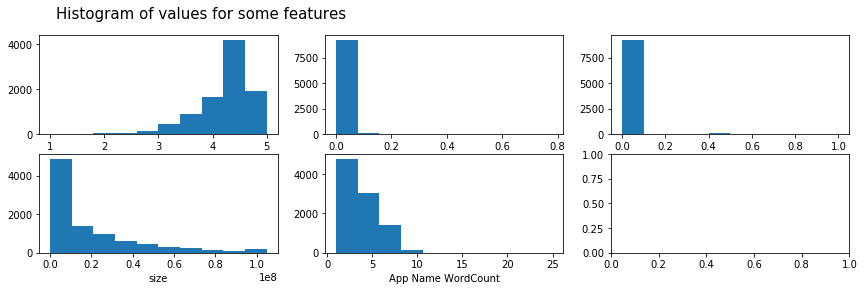

In [18]:
fig, axs = plt.subplots(nrows = 2, ncols = 3);
fig.suptitle('Histogram of values for some features', fontsize = 15);
axs[0][0].hist(dfn['rating']);
axs[0][0].set_xlabel('rating');
axs[0][1].hist(dfn['reviews']);
axs[0][1].set_xlabel('reviews');
axs[0][2].hist(dfn['installs']);
axs[0][2].set_xlabel('installs');
axs[1][0].hist(dfn['size']);
axs[1][0].set_xlabel('size');
axs[1][1].hist(dfn['name_wc']);
axs[1][1].set_xlabel('App Name WordCount');
fig.subplots_adjust(right = 2);

### Let's visualize the correlation between features

#### Correlation between "rating" and the other features

<Figure size 1080x360 with 0 Axes>

Text(0, 0.5, 'Correlation to "rating"')

<BarContainer object of 6 artists>

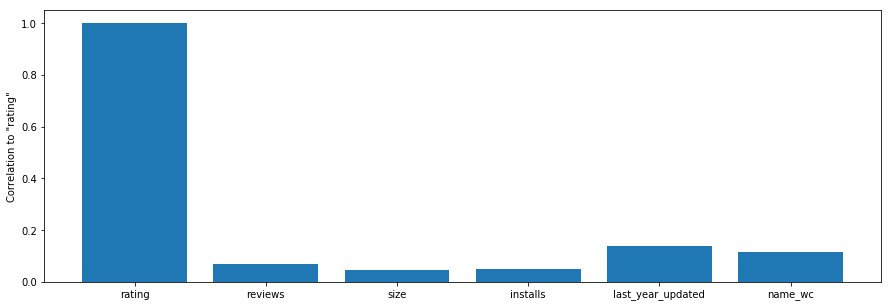

In [19]:
correlation = dfn.corr()['rating']
plt.figure(figsize=(15,5))
plt.ylabel('Correlation to "rating"')

plt.bar(correlation.index.values, correlation)

**Observations**

- *rating* is correlated the most with *last_year_updated*


#### Correlation between all features

<Figure size 800x640 with 0 Axes>

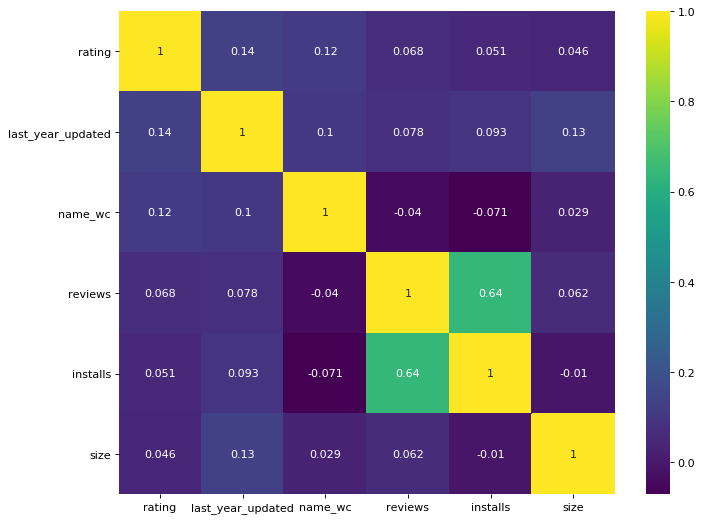

In [20]:
k = len(dfn.columns.values) #number of variables for heatmap
cols = dfn.corr().nlargest(k, 'rating')['rating'].index
cm = dfn[cols].corr()

# enlarge plot
plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')

# plot heatmap
sns.heatmap(cm, annot=True, cmap = 'viridis')

**Observations**

- *reviews* and *installs* are strongly correlated
- *size* and *last_year_updated* may be somehow related

In [21]:
# Because not all features are preprocessed yet, we got only to use 'Reviews' and 'Installs'. 
# This led to terrible results, like an R squared error of 0.002
# But below you can find an example that find a linear model between 'Reviews' and 'Installs' that works well
# It predicts number of 'Reviews' based on 'Installs' with an R squared error of 0.92 

# A linear model

In [22]:
# we use .values because the ML models work with numpy arrays, not pandas dataframes
Y = dfn['reviews'].values
X = dfn[['installs']].values

In [23]:
# In some cases we may need to scale data. There are many types of scallers in the preprocessing module. 
# Here is an example

# from sklearn import preprocessing
# scaler = preprocessing.MinMaxScaler()
# X = scaler.fit_transform(X)
# Y = scaler.fit_transform(Y.reshape(-1,1)).squeeze()

In [24]:
# when creating a ML model, we split data in train and test 
# we train the model on the train data and evaluate its performance on the test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [25]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(x_train, y_train)
print('Train R squared : %.4f' % lr.score(x_train,y_train))
print('Test R squared : %.4f' % lr.score(x_test,y_test))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Train R squared : 0.3746
Test R squared : 0.5583


In [26]:
X_log = np.log(X)
Y_log = np.log(Y)
x_train, x_test, y_train, y_test = train_test_split(X_log, Y_log, test_size = 0.2, random_state = 42)

In [27]:
lr.fit(x_train, y_train)
print('Train R squared : %.4f' % lr.score(x_train,y_train))
print('Test R squared : %.4f' % lr.score(x_test,y_test))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Train R squared : 0.9196
Test R squared : 0.9140


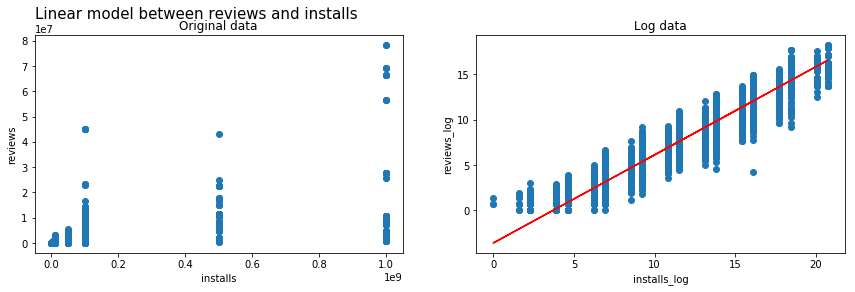

In [28]:
dfn.columns
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2);
fig.suptitle('Linear model between reviews and installs', fontsize = 15)
fig.subplots_adjust(right = 2)
ax1.set_title('Original data')
ax1.scatter(X, Y);
ax1.set_xlabel('installs');
ax1.set_ylabel('reviews');
ax2.set_title('Log data')
ax2.scatter(X_log[:,0], Y_log);
ax2.set_xlabel('installs_log')
ax2.set_ylabel('reviews_log');
y_pred = lr.predict(X_log)
ax2.plot(X_log[:,0], y_pred, c = 'red');

## Trying other modules

In [29]:
Y = dfn['rating'].values
X = dfn[['size', 'installs', 'reviews', 'last_year_updated', 'name_wc']]

In [30]:
from sklearn import svm
from model import Model
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
svr = Model(svm.SVR())
train_score, test_score = svr.use_model((x_train, y_train), (x_test, y_test))
print('Train score : %.4f' % train_score)
print('Test score : %.4f' % test_score)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train score : 0.8440
Test score : 0.0267
